In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
%matplotlib inline

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
my_data = pd.read_csv('/home/lin/教材/Financial_data/data/Ripple.csv')
my_data['Date']=pd.to_datetime(my_data['Date'])
my_data.dtypes

Date          datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume               float64
Market Cap           float64
dtype: object

In [3]:
my_data.set_index('Date', inplace = True)
my_data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2018-01-08,3.36,3.36,2.07,2.46,3.315260e+09,1.303020e+11
2018-01-07,3.09,3.49,3.08,3.38,2.395150e+09,1.198190e+11
2018-01-06,3.02,3.24,2.99,3.09,2.777560e+09,1.170330e+11
2018-01-05,3.30,3.56,2.83,3.05,6.288500e+09,1.278700e+11
2018-01-04,3.12,3.84,3.12,3.20,8.103660e+09,1.207630e+11


In [4]:
my_data.describe()

,Open,High,Low,Close,Volume,Market Cap
count,1619.000000,1619.000000,1619.000000,1619.000000,1.474000e+03,1.619000e+03
mean,0.065686,0.071800,0.061426,0.067220,9.482681e+07,2.423942e+09
std,0.246393,0.279678,0.225367,0.253546,5.595052e+08,9.562257e+09
min,0.002809,0.003082,0.002802,0.002810,8.316000e+03,2.196030e+07
25%,0.006046,0.006161,0.005956,0.006050,2.930168e+05,1.456445e+08
50%,0.007878,0.008014,0.007707,0.007879,7.020645e+05,2.362570e+08
75%,0.016074,0.016893,0.015446,0.016123,2.812955e+06,3.484395e+08
max,3.360000,3.840000,3.120000,3.380000,8.108390e+09,1.303020e+11


In [5]:
close = my_data['Close']
close.head()

Date
2018-01-08    2.46
2018-01-07    3.38
2018-01-06    3.09
2018-01-05    3.05
2018-01-04    3.20
Name: Close, dtype: float64

In [6]:
volume = my_data['Volume'].dropna()
volume.head()

Date
2018-01-08    3.315260e+09
2018-01-07    2.395150e+09
2018-01-06    2.777560e+09
2018-01-05    6.288500e+09
2018-01-04    8.103660e+09
Name: Volume, dtype: float64

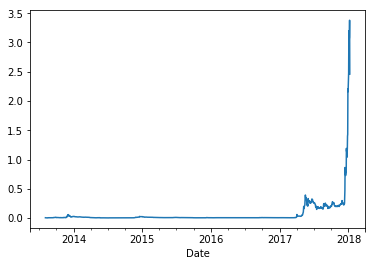

In [7]:
close.plot()

In [8]:
logR = np.log(close).diff()
logR.head()

Date
2018-01-08         NaN
2018-01-07    0.317714
2018-01-06   -0.089705
2018-01-05   -0.013030
2018-01-04    0.048009
Name: Close, dtype: float64

In [9]:
logR.values

array([        nan,  0.31771436, -0.08970462, ...,  0.05783738,
        0.18178723,  0.0468115 ])

In [10]:
logR.drop(logR.index[0], inplace = True)

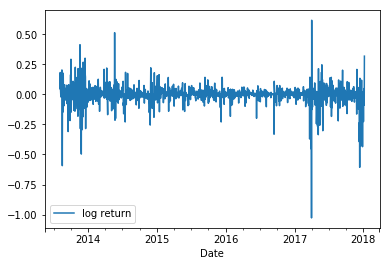

In [11]:
logR.plot()
plt.legend(['log return'])
plt.show()

In [12]:
logR.describe()

count    1618.000000
mean       -0.003731
std         0.079982
min        -1.027356
25%        -0.021177
50%         0.002303
75%         0.021178
max         0.616273
Name: Close, dtype: float64

In [13]:
stats.skew(logR)

-2.181069987839706

In [14]:
stats.kurtosis(logR)

28.450608026769

In [15]:
adfuller(logR) #test for stationary

(-10.837245164813412,
 1.6500888048406184e-19,
 11,
 1606,
 {'1%': -3.4344283205802606,
  '10%': -2.5677289969277726,
  '5%': -2.8633413399051144},
 -3686.8177800988205)

In [16]:
stats.anderson(logR) #test for normal distribution

AndersonResult(statistic=102.33883952356314, critical_values=array([0.575, 0.654, 0.785, 0.916, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [17]:
numSmoothingFactor = 200
#this guy should be a input to the optimized bin number function, it should also take nomalized data
scores = np.zeros(numSmoothingFactor)
binNums = range(1,numSmoothingFactor + 1)
for binNum in binNums:
    frequen, binEdges = np.histogram(logR, bins = binNum)
    numObser = logR.count().astype(float)
    proEst = frequen / numObser
    sumFreqSqua = np.sum(proEst ** 2)
    score = ((2. * binNum) / ( numObser - 1.)) - (sumFreqSqua * (numObser + 1.) * binNum/ (numObser - 1.))
    scores[binNum - 1] = score

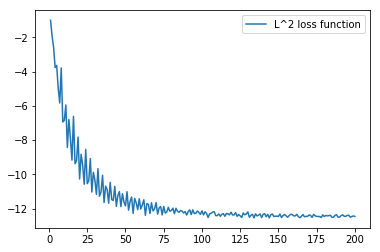

In [18]:
plt.plot(binNums, scores)
plt.legend(['L^2 loss function'])

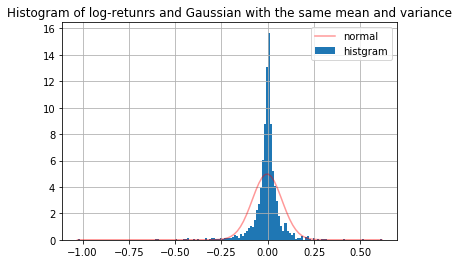

In [19]:
numbins = int(150) 
logR.hist(bins = numbins, normed=True)


mu_log = np.mean(logR)
sigma_log = np.std(logR)
x_ticks = np.linspace(min(logR), max(logR),100)
plt.plot(x_ticks, 1./((2.*np.pi)**0.5 *sigma_log)*np.exp(-((x_ticks - mu_log)/sigma_log)**2/2), 'r', alpha = 0.4)
plt.title('Histogram of log-retunrs and Gaussian with the same mean and variance')
plt.legend(['normal', 'histgram'])

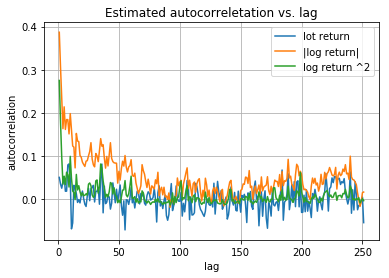

In [20]:
autocorr_logR = [logR.autocorr(lag=_) for _ in range(1,252)]
autocorr_abs_logR = [abs(logR).autocorr(lag=_) for _ in range(1,252)]
autocorr_sqLogR = [(logR ** 2).autocorr(lag=_) for _ in range(1,252)]
plt.plot(range(1, 252),autocorr_logR, range(1, 252), autocorr_abs_logR, range(1, 252), autocorr_sqLogR )
plt.title('Estimated autocorreletation vs. lag')
plt.legend(['lot return', '|log return|', 'log return ^2'], loc = 1)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.grid(True)

In [21]:
posiR = logR[logR > 0].dropna()
negaR = logR[logR <= 0].dropna()

In [22]:
np.unique(posiR > 0)

array([ True])

In [23]:
np.unique(negaR <= 0)

array([ True])

In [24]:
sortedPosiR = posiR.sort_values()
sortedNegaR = (-negaR).sort_values()
numObs = logR.count()

In [25]:
sortedNegaR.count()
numObs

1618

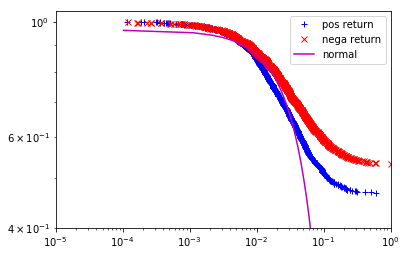

In [26]:
plt.loglog(sortedPosiR, 1 - (range(1, sortedPosiR.count() + 1))/(numObs + 1), '+b')
plt.loglog(sortedNegaR, 1 - (range(1, sortedNegaR.count() + 1))/(numObs + 1), 'xr')
domain = np.linspace(max(abs(logR))/10000, max(abs(logR)), 1000)
plt.loglog(domain, 1 - (stats.norm.cdf(domain, mu_log, sigma_log) - 0.5) * 2, 'm')
#why do this " - 0.5) * 2)"
plt.ylim([4e-1, 1.05])
plt.xlim([1e-5, 1])
plt.legend(['pos return', 'nega return', 'normal'], loc = 1)
#plt.grid(True)

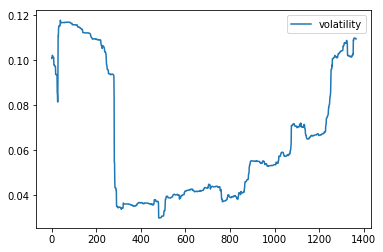

In [27]:
window = 252
cumlogR = logR.cumsum()
cumlogRSq = (logR ** 2).cumsum()
sqRunAvg = (cumlogRSq[cumlogRSq.index[window :]].values - cumlogRSq[cumlogRSq.index[: cumlogRSq.count() - window]].values)/window
RuningAvg = (cumlogR[cumlogR.index[window :]].values - cumlogR[cumlogR.index[: cumlogR.count() - window]].values)/window
volatility = np.sqrt(sqRunAvg - RuningAvg ** 2)
plt.plot(volatility)
plt.legend(['volatility'])

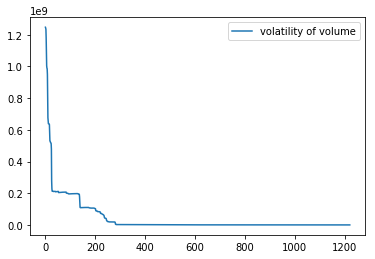

In [28]:
cumlogR = volume.cumsum()
cumlogRSq = (volume ** 2).cumsum()
sqRunAvg = (cumlogRSq[cumlogRSq.index[window :]].values - cumlogRSq[cumlogRSq.index[: cumlogRSq.count() - window]].values)/window
RuningAvg = (cumlogR[cumlogR.index[window :]].values - cumlogR[cumlogR.index[: cumlogR.count() - window]].values)/window
volatility = np.sqrt(sqRunAvg - RuningAvg ** 2)
plt.plot(volatility)
plt.legend(['volatility of volume'])

((array([-3.33382299, -3.07867138, -2.93690334, ...,  2.93690334,
          3.07867138,  3.33382299]),
  array([-1.02735576, -0.60688528, -0.59305533, ...,  0.41286557,
          0.5129271 ,  0.61627274])),
 (0.06868394466179814, -0.0037305437508001076, 0.8574445755399429))

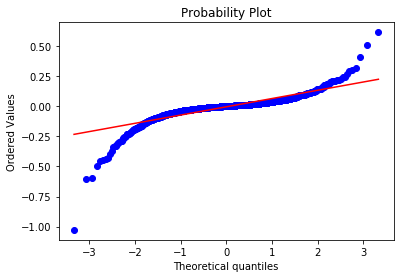

In [29]:
stats.probplot(logR, plot = plt)

((array([-2.57849546, -1.40073654, -1.0158311 , ...,  1.02033264,
          1.40523808,  2.582997  ]),
  array([-1.02735576, -0.60688528, -0.59305533, ...,  0.41286557,
          0.5129271 ,  0.61627274])),
 (0.5157405255822755, -0.004891357099224782, 0.88690956583634))

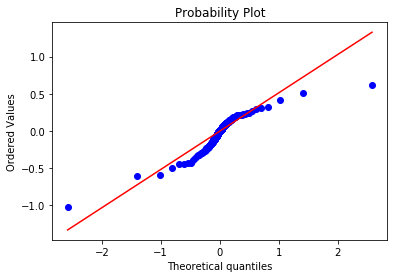

In [30]:
para = stats.t.fit(logR, loc = mu_log, scale = sigma_log)

stats.probplot(logR, dist = stats.t, sparams = para, plot = plt)

((array([-0.34552099, -0.32386777, -0.31154851, ...,  0.42230229,
          0.43902332,  0.46706101]),
  array([-1.02735576, -0.60688528, -0.59305533, ...,  0.41286557,
          0.5129271 ,  0.61627274])),
 (0.5120873376315548, -0.010517763842830301, 0.8368291330151145))

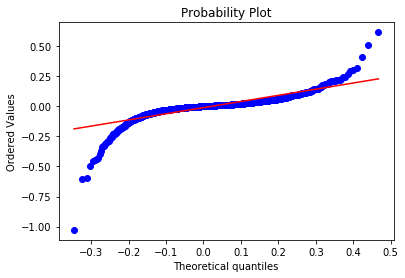

In [31]:
para = stats.genextreme.fit(logR, loc = mu_log, scale = sigma_log)
stats.probplot(logR, dist = stats.genextreme, sparams = para, plot = plt)

In [32]:
para

(0.18617866260222218, -0.03836457311593163, 0.1231676870505412)

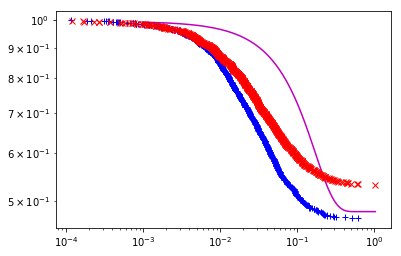

In [35]:
domain = np.linspace(max(abs(logR))/1000, max(abs(logR)), 1000)
plt.loglog(domain, 1 - (stats.genextreme.cdf(domain, c = 0.18617866260222218, loc = -0.03836457311593163, scale =0.1231676870505412) - 0.48), 'm')
plt.loglog(sortedPosiR, 1 - (range(1, sortedPosiR.count() + 1))/(numObs + 1), '+b')
plt.loglog(sortedNegaR, 1 - (range(1, sortedNegaR.count() + 1))/(numObs + 1), 'xr')

In [34]:
stats.genextreme.cdf(domain, c = 0.18617866260222218, loc = -0.03836457311593163, scale =0.1231676870505412)

array([0.48718572, 0.49029163, 0.49339475, 0.49649491, 0.49959193,
       0.50268564, 0.50577587, 0.50886243, 0.51194517, 0.51502392,
       0.51809851, 0.52116876, 0.52423452, 0.52729563, 0.53035191,
       0.53340322, 0.53644939, 0.53949026, 0.54252567, 0.54555548,
       0.54857953, 0.55159767, 0.55460974, 0.5576156 , 0.5606151 ,
       0.56360809, 0.56659443, 0.56957399, 0.57254661, 0.57551215,
       0.57847049, 0.58142148, 0.58436499, 0.58730088, 0.59022903,
       0.59314931, 0.59606158, 0.59896573, 0.60186162, 0.60474914,
       0.60762816, 0.61049856, 0.61336023, 0.61621304, 0.6190569 ,
       0.62189167, 0.62471726, 0.62753355, 0.63034044, 0.63313782,
       0.63592558, 0.63870363, 0.64147186, 0.64423018, 0.64697848,
       0.64971668, 0.65244467, 0.65516238, 0.6578697 , 0.66056655,
       0.66325284, 0.66592849, 0.66859341, 0.67124753, 0.67389076,
       0.67652303, 0.67914426, 0.68175437, 0.6843533 , 0.68694096,
       0.6895173 , 0.69208224, 0.69463572, 0.69717768, 0.69970